# Deep Learning (Approach #4) for Microsoft Malware

### Load Train.csv

In [1]:
import pandas as pd, numpy as np, os, gc

FE = ['EngineVersion','AppVersion','AvSigVersion','Census_OSVersion']

OHE = [ 'RtpStateBitfield','IsSxsPassiveMode','DefaultBrowsersIdentifier',
        'AVProductStatesIdentifier','AVProductsInstalled', 'AVProductsEnabled',
        'CountryIdentifier', 'CityIdentifier', 
        'GeoNameIdentifier', 'LocaleEnglishNameIdentifier',
        'Processor', 'OsBuild', 'OsSuite',
        'SmartScreen','Census_MDC2FormFactor',
        'Census_OEMNameIdentifier', 
        'Census_ProcessorCoreCount',
        'Census_ProcessorModelIdentifier', 
        'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
        'Census_HasOpticalDiskDrive',
        'Census_TotalPhysicalRAM', 'Census_ChassisTypeName',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches',
        'Census_InternalPrimaryDisplayResolutionHorizontal',
        'Census_InternalPrimaryDisplayResolutionVertical',
        'Census_PowerPlatformRoleName', 'Census_InternalBatteryType',
        'Census_InternalBatteryNumberOfCharges',
        'Census_OSEdition', 'Census_OSInstallLanguageIdentifier',
        'Census_GenuineStateName','Census_ActivationChannel',
        'Census_FirmwareManufacturerIdentifier',
        'Census_IsTouchEnabled', 'Census_IsPenCapable',
        'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer',
        'Wdft_RegionIdentifier']


dtypes = {}
for x in FE+OHE: dtypes[x] = 'category'
dtypes['MachineIdentifier'] = 'str'
dtypes['HasDetections'] = 'int8'


df_train = pd.read_csv('../input/train.csv', usecols=dtypes.keys(), dtype=dtypes)
print ('Loaded',len(df_train),'rows of TRAIN.CSV!')


sm = 2000000
df_train = df_train.sample(sm)
print ('Only using',sm,'rows to train and validate')
x=gc.collect()

Loaded 8921483 rows of TRAIN.CSV!
Only using 2000000 rows to train and validate


# Statistically Encode Variables
We will encode the variables in `FE` by frequency and all the variables in `OHE` will need statistical one-hot-encoding. In total, we only consider 43 variables and ignore the rest.
  
If we encode everything using OHE, the number of features produced are extremely high since there are 211,562 values. (This is when we leave aside Census_OEMModelIdentifier's 175,366 values or Census_SystemVolumeTotalCapacity's 536,849).

To solve this, we take help of a statistical trick. First we'll assume we have a random sample. Then we test the following hypotheses :   

 $$H_0: \text{Prob(HasDetections=1 given value is present)} = 0.5 $$ 
 $$H_A: \text{Prob(HasDetections=1 given value is present)} \ne 0.5$$  
    
The test statistic z-value equals \\( \hat{p} \\), the observed HasDetections rate given value is present, minus 0.5 divided by the standard deviation of \\( \hat{p} \\). The Central Limit Theorem tells us

$$\text{z-value} = \frac{\hat{p}-0.5}{SD(\hat{p})} = 2 (\hat{p} - 0.5)\sqrt{n} $$

where \\(n\\) is the number of occurences of the value. If abs(\\(z\\)) > 2.0, we are 95% confident that Prob(HasDetections=1 given value is present) is not equal to 0.5 and we will include a boolean for this value in our model. We would employ a \\(z\\) threshold of 5.0 and require \\( 10^{-7}n>0.005 \\). This adds 350 new boolean variables (instead of naively one-hot-encoding 211,562).

In [2]:
import math

def nan_check(x):
    if isinstance(x,float):
        if math.isnan(x):
            return True
    return False

def encode_FE(df,column,verbose=1):
    freq = df[column].value_counts(dropna=False)
    n = column+"_FE"
    df[n] = df[column].map(freq)/freq.max()
    if verbose==1:
        print('FE encoded',column)
    return [n]

def encode_OHE(df, col, filter, zvalue, tar='HasDetections', m=0.5, verbose=1):
    cv = df[col].value_counts(dropna=False)
    cvd = cv.to_dict()
    vals = len(cv)
    th = filter * len(df)
    sd = zvalue * 0.5/ math.sqrt(th)
    #print(sd)
    n = []; ct = 0; d = {}
    for x in cv.index:
        try:
            if cv[x]<th: break
            sd = zvalue * 0.5/ math.sqrt(cv[x])
        except:
            if cvd[x]<th: break
            sd = zvalue * 0.5/ math.sqrt(cvd[x])
        if nan_check(x): r = df[df[col].isna()][tar].mean()
        else: r = df[df[col]==x][tar].mean()
        if abs(r-m)>sd:
            nm = col+'_BE_'+str(x)
            if nan_check(x): df[nm] = (df[col].isna()).astype('int8')
            else: df[nm] = (df[col]==x).astype('int8')
            n.append(nm)
            d[x] = 1
        ct += 1
        if (ct+1)>=vals: break
    if verbose==1:
        print('OHE encoded',col,'- Created',len(d),'booleans')
    return [n,d]


def encode_OHE_test(df,col,dt):
    n = []
    for x in dt: 
        n += encode_BE(df,col,x)
    return n


def encode_BE(df,col,val):
    n = col+"_BE_"+str(val)
    if nan_check(val):
        df[n] = df[col].isna()
    else:
        df[n] = df[col]==val
    df[n] = df[n].astype('int8')
    return [n]

In [3]:
cols = []; dd = []

# ENCODE NEW
for x in FE:
    cols += encode_FE(df_train,x)
for x in OHE:
    tmp = encode_OHE(df_train,x,0.005,5)
    cols += tmp[0]; dd.append(tmp[1])
print('Encoded',len(cols),'new variables')

# REMOVE OLD
for x in FE+OHE:
    del df_train[x]
print('Removed original',len(FE+OHE),'variables')
x = gc.collect()

FE encoded EngineVersion
FE encoded AppVersion
FE encoded AvSigVersion
FE encoded Census_OSVersion
OHE encoded RtpStateBitfield - Created 2 booleans
OHE encoded IsSxsPassiveMode - Created 1 booleans
OHE encoded DefaultBrowsersIdentifier - Created 2 booleans
OHE encoded AVProductStatesIdentifier - Created 10 booleans
OHE encoded AVProductsInstalled - Created 3 booleans
OHE encoded AVProductsEnabled - Created 2 booleans
OHE encoded CountryIdentifier - Created 40 booleans
OHE encoded CityIdentifier - Created 11 booleans
OHE encoded GeoNameIdentifier - Created 31 booleans
OHE encoded LocaleEnglishNameIdentifier - Created 26 booleans
OHE encoded Processor - Created 2 booleans
OHE encoded OsBuild - Created 6 booleans
OHE encoded OsSuite - Created 2 booleans
OHE encoded SmartScreen - Created 4 booleans
OHE encoded Census_MDC2FormFactor - Created 5 booleans
OHE encoded Census_OEMNameIdentifier - Created 19 booleans
OHE encoded Census_ProcessorCoreCount - Created 6 booleans
OHE encoded Census_P

In [4]:
cols

['EngineVersion_FE',
 'AppVersion_FE',
 'AvSigVersion_FE',
 'Census_OSVersion_FE',
 'RtpStateBitfield_BE_7',
 'RtpStateBitfield_BE_0',
 'IsSxsPassiveMode_BE_0',
 'DefaultBrowsersIdentifier_BE_nan',
 'DefaultBrowsersIdentifier_BE_239',
 'AVProductStatesIdentifier_BE_53447',
 'AVProductStatesIdentifier_BE_7945',
 'AVProductStatesIdentifier_BE_47238',
 'AVProductStatesIdentifier_BE_62773',
 'AVProductStatesIdentifier_BE_23657',
 'AVProductStatesIdentifier_BE_49480',
 'AVProductStatesIdentifier_BE_41571',
 'AVProductStatesIdentifier_BE_22728',
 'AVProductStatesIdentifier_BE_43856',
 'AVProductStatesIdentifier_BE_43927',
 'AVProductsInstalled_BE_1',
 'AVProductsInstalled_BE_2',
 'AVProductsInstalled_BE_3',
 'AVProductsEnabled_BE_1',
 'AVProductsEnabled_BE_2',
 'CountryIdentifier_BE_43',
 'CountryIdentifier_BE_141',
 'CountryIdentifier_BE_207',
 'CountryIdentifier_BE_66',
 'CountryIdentifier_BE_89',
 'CountryIdentifier_BE_97',
 'CountryIdentifier_BE_214',
 'CountryIdentifier_BE_158',
 'Count

# Build and Train Network
We will a build a 3 layer fully connected network with 100 neurons on each hidden layer. We will use ReLU activation, Batch Normalization, 40% Dropout, Adam Optimizer, and Decaying Learning Rate. After each epoch, we will call a custom Keras callback to display the current AUC and continually save the best model.

In [14]:
from keras import callbacks
from sklearn.metrics import roc_auc_score

class printAUC(callbacks.Callback):
    def __init__(self, X_train, y_train):
        super(printAUC, self).__init__()
        self.bestAUC = 0
        self.X_train = X_train
        self.y_train = y_train
        
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(np.array(self.X_train))
        auc = roc_auc_score(self.y_train, pred)
        print("Train AUC: " + str(auc))
        pred = self.model.predict(self.validation_data[0])
        auc = roc_auc_score(self.validation_data[1], pred)
        print ("Validation AUC: " + str(auc))
        if (self.bestAUC < auc) :
            self.bestAUC = auc
            self.model.save("bestNet.h5", overwrite=True)
        return

In [15]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam

#SPLIT TRAIN AND VALIDATION SET
X_train, X_val, Y_train, Y_val = train_test_split(
    df_train[cols], df_train['HasDetections'], test_size = 0.5)

# BUILD MODEL
model = Sequential()
model.add(Dense(200,input_dim=len(cols)))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.01), loss="binary_crossentropy", metrics=["accuracy"])
annealer = LearningRateScheduler(lambda x: 1e-2 * 0.95 ** x)


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               69800     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 200)               800       
_________________________________________________________________
activation_13 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 300)               60300     
_________________________________________________________________
dropout_11 (Dropout)         (None, 300)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 300)               1200      
__________

In [16]:
history = model.fit(X_train,Y_train, batch_size=64, epochs = 10, callbacks=[annealer,
          printAUC(X_train, Y_train)], validation_data = (X_val,Y_val), verbose=2)

Train on 1000000 samples, validate on 1000000 samples
Epoch 1/10
 - 147s - loss: 0.6375 - acc: 0.6264 - val_loss: 0.6331 - val_acc: 0.6265
Train AUC: 0.6964997598053656
Validation AUC: 0.6946721018064518
Epoch 2/10
 - 145s - loss: 0.6310 - acc: 0.6338 - val_loss: 0.6331 - val_acc: 0.6356
Train AUC: 0.7008493945335483
Validation AUC: 0.6978986502002342
Epoch 3/10
 - 146s - loss: 0.6285 - acc: 0.6368 - val_loss: 0.6330 - val_acc: 0.6371
Train AUC: 0.7033434656994517
Validation AUC: 0.699447536737285
Epoch 4/10
 - 148s - loss: 0.6271 - acc: 0.6385 - val_loss: 0.6267 - val_acc: 0.6415
Train AUC: 0.7065957514621586
Validation AUC: 0.7015278013610634
Epoch 5/10
 - 145s - loss: 0.6256 - acc: 0.6396 - val_loss: 0.6269 - val_acc: 0.6381
Train AUC: 0.7090458017801575
Validation AUC: 0.7028525883509825
Epoch 6/10
 - 145s - loss: 0.6248 - acc: 0.6406 - val_loss: 0.6240 - val_acc: 0.6423
Train AUC: 0.7103421083402411
Validation AUC: 0.7030899282633717
Epoch 7/10
 - 145s - loss: 0.6239 - acc: 0.6419

([<matplotlib.axis.XTick at 0x7eb32fdae048>,
 <a list of 10 Text xticklabel objects>)

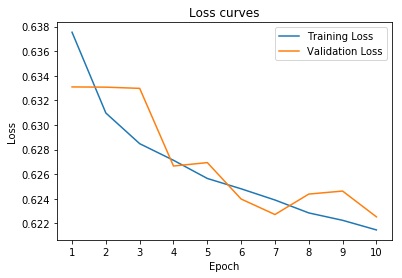

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.xticks(range(10), range(1, 11))

([<matplotlib.axis.XTick at 0x7eb327fd62b0>,
 <a list of 10 Text xticklabel objects>)

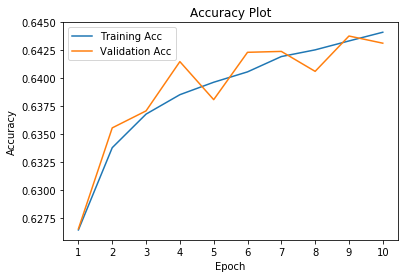

In [30]:
plt.plot(history.history['acc'], label='Training Acc')
plt.plot(history.history['val_acc'], label='Validation Acc')
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.xticks(range(10), range(1, 11))

# Predict Test and Submit to Kaggle
Even after deleting the training data, our network still needs lot of our available RAM, we'll need to load in test.csv by chunks and predict by chunks.

In [17]:
del df_train
del X_train, X_val, Y_train, Y_val
x = gc.collect()

# LOAD BEST SAVED NET
from keras.models import load_model
model = load_model('bestNet.h5')

pred = np.zeros((7853253,1))
id = 1
chunksize = 2000000
for df_test in pd.read_csv('../input/test.csv', 
            chunksize = chunksize, usecols=list(dtypes.keys())[0:-1], dtype=dtypes):
    print ('Loaded',len(df_test),'rows of TEST.CSV!')
    # ENCODE TEST
    cols = []
    for x in FE:
        cols += encode_FE(df_test,x,verbose=0)
    for x in range(len(OHE)):
        cols += encode_OHE_test(df_test,OHE[x],dd[x])
    # PREDICT TEST
    end = (id)*chunksize
    if end>7853253: end = 7853253
    pred[(id-1)*chunksize:end] = model.predict(df_test[cols])
    print('  encoded and predicted part',id)
    id += 1

Loaded 2000000 rows of TEST.CSV!
  encoded and predicted part 1
Loaded 2000000 rows of TEST.CSV!
  encoded and predicted part 2
Loaded 2000000 rows of TEST.CSV!
  encoded and predicted part 3
Loaded 1853253 rows of TEST.CSV!
  encoded and predicted part 4


In [18]:
# SUBMIT TO KAGGLE
df_test = pd.read_csv('../input/test.csv', usecols=['MachineIdentifier'])
df_test['HasDetections'] = pred
df_test.to_csv('submission2.csv', index=False)